# Voting Prediction By Tweets Classification

## Introduction
Twitter is regarded as one of the major resources of free text. In addition to the more structured relational data, free text makes up one of the most common types of widely available data: web pages, unstructured “comment” fields in many relational databases, and many other easily-obtained large sources of data naturally come in free text form. However, free text, unlike numeric data, by its very definition usually needs to have meaning to the people who are reading that data. It might be good to think of a way of analyzing free text in a more objective way as we usually deal with numeric data. Natural Language Processing (NLP) provides us a good way to extract and generalize information from free text. Methods like bag-of-word models, TFIDF vectors, and (simple n-gram) language models are widely used in processing raw text information from social media like Twitter and many other fields.

This project intends to analyze the Twitter data extracted using [this](https://dev.twitter.com/overview/api) api. Some data preprocessing has already been done. Only tweets posted by the following six Twitter accounts are kept: `realDonaldTrump, mike_pence, GOP, HillaryClinton, timkaine, TheDemocrats`.

For every tweet, only two pieces of information are kept:
- `screen_name`: the Twitter handle of the user tweeting and
- `text`: the content of the tweet.

The training set contains both the `screen_name` and `text` of each tweet; the test set only contains the `text`.

The overarching goal of the project is to infer the political inclination (whether **R**epublican or **D**emocratic) of the author from the tweet text. The ground truth (i.e., true class labels) are determined from the `screen_name` of the tweet as follows:
- **R**: `realDonaldTrump, mike_pence, GOP`
- **D**: `HillaryClinton, timkaine, TheDemocrats`

Therefore, the problem can be treated as a binary classification. The analysis structure is indicated as follows:

1. **preprocessing**: clean up the raw tweet text using the various functions offered by [the Natural Language Toolkit (`nltk`)](http://www.nltk.org/genindex.html).
2. **features**: construct bag-of-words feature vectors.
3. **classification**: learn a binary classification model using [`scikit-learn`](http://scikit-learn.org/stable/modules/classes.html). 

Note that `nltk` supports optional corpora, toy grammars, trained models, etc. we also have to manually install the stopwords list (high frequency words in English) and `WordNetLemmatizer`.

## Installation

Before getting started, you'll need to install various packages that will be used in this project. It is strongly recommanded to use Anaconda since all the open source packages can be individually installed from the Anaconda repository. By calling

   $ pip install [packages you want to install]
   
Or

   $ conda install [packages you want to install]
   
Anaconda compiles and builds all the packages in the Anaconda repository itself. The packages required are listed as follow.

You can also refer to requirements.txt to figure out the required packages.

In [1]:
import nltk
import collections
import string
import numpy as np
import sklearn
import gzip
import csv
import re
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import HTML, display
import tabulate


# Install the required pacakges
try:
    lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
    stopwords=nltk.corpus.stopwords.words('english')
except LookupError:
    print("Installation Failed")
        

def nltk_download():
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')
    
nltk_download()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DavidGuo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DavidGuo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DavidGuo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Text Processing

By inspecting the raw tweets, we notice that the tweets are not only formatted with alphanumeric characters (also including special characters). Some of them may not have semantic meaning. Therefore we need to lemmatize and tokenize the raw tweets into separate word string for further analysis. Here we predefine a set of rule of thumb on what a "meaningful" word actually means. The basic principles of tokenizing tweets are indicated as follows: 

The tokens must:

1. be in lower case.
2. appear in the same order as in the raw text.
3. be in their lemmatized form, if one exists. If a word cannot be lemmatized, do not include it in the output.
4. **not** contain any characters other than numbers and digits.
   1. remove trailing `'s`: `Children's` becomes `children`
   2. omit other apostrophes: `don't` becomes `dont`
   3. break tokens at other punctuation and/or unicode characters: `word-of-mouth` becomes `word`, `of`, `mouth` 
5. if the lemmatized form is a stopword, it should not appear in the output
6. not include the parts of any t.co urls. Many tweets contain URLs from the domain `t.co`; All URLs with `t.co` domain should be striped.

**Stopwords** are words that appear very often in text, usually playing a grammatical role ("and", "a", etc.). When comparing text similarity, these are not very useful; so we eliminate them at this stage. (NLTK provides us with a list of stopwords for English.)

We also don't want to include stopwords in our tokens, we make it as an optional parameter in our function so that we can expand its meaning in addition to the stopwords for English provided NLTK package.


In [2]:
# This function is used to tokenize word string by row readed from csv
def preprocess(text, stopwords={}, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    # handle URL
    text = re.sub(r'(http|https)://t.co/[a-zA-Z0-9]{10}', ' ', text)
    
    # remove trailing "'s"
    text = text.replace("'s", "")
    
    # remove trailing "'S"
    text = text.replace("'S", "")
    
    # omit other apostrophes
    text = text.replace("'", "")
    
    # replace with whitespace
    for c in text:
        if c in string.ascii_letters or c in string.digits:
            continue
        else:
            text = text.replace(c, " ")
    
    # to lower case
    text = text.lower()
    
    # tokenize with whitespace
    text = nltk.word_tokenize(text)
    
    # lemmatize each word in the text list
    text = [lemmatizer.lemmatize(w) for w in text]
    
    # remove the word in the stoplist
    # stopwords = set(nltk.corpus.stopwords.words('english'))
    text = [w for w in text if w not in stopwords]
        
    return text


The above `preprocess` function is used to tokenize the word string by row readed from csv file. The following functions implemented the `preprocess` function defined above to tokenize the tweets row by row.

In [3]:
# This function reads the csv file and map the preprocess function to each csv row
def read_csv(stem, process=lambda x: x):
    with gzip.open(f"{stem}.csv.gz", "rt", newline='', encoding="UTF-8") as file:
        csvr = csv.reader(file)
        next(csvr)
        return list(map(process, csvr))

def is_republican(r):
    return r in ["realDonaldTrump", "mike_pence", "GOP"]

# This function processes the whole dataset and allows customized stopwords 
def read_data(extra_stopwords=set()):
    stopwords = set(nltk.corpus.stopwords.words('english')) | set(["http", "co", "rt", "amp"]) | extra_stopwords
    data_train = read_csv("tweets_train", process=lambda r: (is_republican(r[0]), preprocess(r[1], stopwords)))
    data_test = read_csv("tweets_test", process=lambda r: preprocess(r[0], stopwords))
    
    """Reads the dataset from the csv.gz files
    
    return : Tuple[data_train, data_test]
        data_train : List[Tuple[is_republican, tokenized_tweet]]
            is_republican : bool -- True if tweet is from a republican
            tokenized_tweet : List[str] -- the tweet, tokenized by preprocess()
    """
    
    return (data_train, data_test)

Now let's take a look at our processed training dataset.

In [4]:
p_data_train, p_data_test = read_data()
p_data_train[0]

(True,
 ['gopconvention',
  'oregon',
  'vote',
  'today',
  'mean',
  '62',
  'day',
  'gopconvention'])

The "True" symbol means that the author of the tweet text inclines to Republican, and vice vera. The followed list of words is a combination of "meaningful" words defined by our previous principles. We can also inspect our testing dataset. The only difference is that it lacks "True" or "False" symbols. We need to predict it using the provided tweets text in the following steps.

In [5]:
p_data_test[0]

['comprehensive', 'look', 'many', 'lie', 'offense', 'donald', 'trump']

## Feature Construction

Before we jump into the feature construction section, a few terminologies should be noted:

1. `document`: an individual group of free text data (in our case is each row of tweet)
2. `corpus`: a collection of documents
3. `vocabulary`: a set of all unique words/tokens in the corpus

The next step is to derive feature vectors from the tokenized tweets. In this section, we will construct a bag-of-words [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) feature vector.

The number of possible words is prohibitively large, and not all words are useful for our task. We will begin by filtering the vectors using a common heuristic:

We calculate a frequency distribution of words in the corpus, and remove words at the head (most frequent) and tail (least frequent) of the distribution. Most frequently used words (often called stopwords) provide very little information about the similarity of two pieces of text; we have already removed these. Words with extremely low frequency tend to be typos.

We will now implement a function which counts the number of times that each token is used in the training corpus.

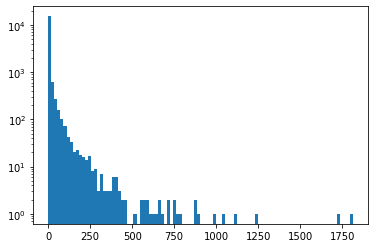

In [6]:
# A helper function to plot the distribution
def get_distribution_helper(get_distribution):
    data_train, data_test = read_data()
    dist = get_distribution(data_train)
    if dist is None:
        return

    plt.hist(dist.values(), bins=100)
    plt.yscale('log')

# A function to count the frequency of words
def get_distribution(data_train):
    lst = [ele[1] for ele in data_train]
    lst = [i for j in lst for i in j]
    counter = collections.Counter(lst)
    return counter
    """ Calculates the word count distribution, excluding stopwords.

    args: data_train -- the training data

    return : collections.Counter -- the distribution of word counts
    """
get_distribution_helper(get_distribution)

Notice the distribution looks exponential, even with a logarithmic y-axis. There are a lot words that appear only once, so we need to figure out what these words are and eliminate them from the dataset accordingly.

In [7]:
def get_rare_words(dist):
    new_stopwords = set()
    for word in dist:
        if dist[word] == 1:
            new_stopwords.add(word)
            
    return new_stopwords
    
    """use the word count information from the training data to find more stopwords

    args: dist: collections.Counter -- the output of get_distribution

    returns : Set[str] -- a set of all words that appear exactly once in the training data
    """
    

We might notice that in the previous steps each time we call the preprocess function, it takes a few seconds to run. Here we provide a wrapper function to cache the preprocessed data. This helps it not take quite as long to re-run. If you change anything above this cell, re-run this cell to clear the cache.

In [8]:
global PREPROCESSED_DATA_CACHE
PREPROCESSED_DATA_CACHE = None

def get_data():
    global PREPROCESSED_DATA_CACHE
    if PREPROCESSED_DATA_CACHE is None:
        data_train, data_test = read_data()
        dist = get_distribution(data_train)
        new_stopwords = get_rare_words(dist)
        PREPROCESSED_DATA_CACHE = read_data(new_stopwords)

    return PREPROCESSED_DATA_CACHE

## Vectorizing

Now we have each tweet as a list of words, excluding words with high- and low-frequencies. We want to convert these into a sparse feature matrix, where each row corresponds to a tweet and each column to a possible word. We can use `scikit-learn`'s [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to do this quite easily.

Note that though: `TfidfVectorizer` expects the input to be a string, and (by default) it perfoms its own analyzing. We have to override that behavior by passing in `do_nothing` to the constructor as an optional parameter.

The vectorizing method uses [scikit-learn vectorizer classes](https://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes) and refers to a [tech blog](http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/)


In [9]:
# Helper function, will be passed twice
def do_nothing(x):
    return x

def create_features(train_data, test_data):

    train_labels = None
    train_features = None
    test_features = None
    
    train_doc = [ele[1] for ele in train_data]
    train_labels = np.array([ele[0] for ele in train_data])
    
    
    tfidf = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = do_nothing,
    preprocessor = do_nothing,
    token_pattern = None)
    
    tfidf.fit(train_doc)
    test_features = tfidf.transform(test_data)
    train_features = tfidf.transform(train_doc)
    return (train_features, train_labels, test_features)
    
    """creates the feature matrices and label vector for the training and test sets.

    args:
        train_data : List[Tuple[is_republican, tweet_words]]
        is_republican : bool -- True if Republican, False otherwise
        tweet_words : List[str] -- the processed tweet tokens
        test_data : List[List[str]] -- a list of processed tweets

    returns: Tuple[train_features, train_labels, test_features]
        train_features : scipy.sparse.csr.csr_matrix -- feature matrix for the training set
        train_labels : np.array[num_train] -- a numpy vector, where 1 stands for Republican and 0 stands for Democrat 
        test_features : scipy.sparse.csr.csr_matrix -- feature matrix for the test set
    """
train_features, train_labels, test_features = create_features(*get_data())


In [10]:
train_features

<17298x8714 sparse matrix of type '<class 'numpy.float64'>'
	with 161480 stored elements in Compressed Sparse Row format>

In [11]:
test_features

<1000x8714 sparse matrix of type '<class 'numpy.float64'>'
	with 9037 stored elements in Compressed Sparse Row format>

Observe that the created matrices are very sparse, indicating that some words seldom appear in most of the tweets.

Now that we have the features, the next step will be the classification:

## Classification

In this section, we are going to put it all together and train the classification model.

We use the Support Vector Machine [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) to build the classifier.

At the heart of an SVM is the concept of a _kernel function_, which determines the distance between two data points. The hypothesis function of SVM, which maps our inputs to the prediction fields, can refer either to a linear hypothesis function or a particular form of nonlinear hypothesis known as a kernal hypothesis.  `sklearn.svm.SVC` natively supports four kernel functions: `linear`, `poly`, `rbf`, `sigmoid`. For this problem, we will use the `linear` kernel.

In this section, we will:

1. build a classifier using the `linear` kernel,
2. train it using the training set,
3. evaluate the trained model on the training set (might be better to use a validation set), and then
4. use it to predict classification on our test set.


In [12]:
#  Function to build a linear classifier
def learn_classifier(train_features, train_labels, kernel="linear"):


    model = SVC(kernel='linear', gamma = 'auto')
    model.fit(train_features, train_labels)
        
    return model

    """learns a classifier from the input features and labels using a specified kernel function

    args:
        train_features: scipy.sparse.csr.csr_matrix -- sparse matrix of features
        train_labels : numpy.ndarray(bool): binary vector of class labels
        kernel : str -- kernel function to be used with classifier, must be (linear|poly|rbf|sigmoid)

    return : sklearn.svm.classes.SVC -- classifier
    """

### F1 Score

Now that we have trained a classifier, the next step is to measure its performance. This step is necessary to select the best model among a given set of models, or even tune hyperparameters for a given model.

F1 score is one of the statistical ways to measure the accuracy of our classifications. F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. Here is a link to wiki of the description of [$F 1$ score](https://en.wikipedia.org/wiki/F1_score).

The following functions implement the calculation of F1 score.

In [13]:
def f1(pred, ground):

    pred = np.array(pred, dtype=bool)
    ground = np.array(ground, dtype=bool)

    TP, TN, FP, FN = 0, 0, 0, 0
    
    for i, v in enumerate(ground):
        if ground[i]:
            if ground[i] == pred[i]:
                TP += 1
            else:
                FN += 1
        else:
            if ground[i] == pred[i]:
                TN += 1
            else:
                FP += 1
    

    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    F1 = 2 * (precision*recall) / (precision+recall)
    return F1

    """ evaluates a classifier based on a supplied validation data

    args:
        pred: numpy.ndarray(bool) -- predictions
        ground: numpy.ndarray(bool) -- known ground-truth values
    
    return : double -- the F1 score of the predictions
    """

We can now calculate the F1 score on our training dataset.

In [14]:
def evaluate_test(evaluate):
    train_features, train_labels, _ = create_features(*get_data())
    test.true(np.abs(evaluate(train_features, train_labels, 'linear') - 0.9538984242282234) < 1e-5)


def evaluate(train_features, train_labels, kernel="linear"):
    model = learn_classifier(train_features, train_labels, kernel="linear")
    pred_labels = model.predict(train_features)
    
    F1 = f1(pred_labels, train_labels)
    return F1
    """train the classifier and report the F1 score on the training set
    
    args:
        train_features: scipy.sparse.csr.csr_matrix -- sparse matrix of features
        train_labels : numpy.ndarray(bool): binary vector of class labels
        kernel : str -- kernel function to be used with classifier, must be (linear|poly|rbf|sigmoid)

    return : double -- the F1 score of the predictions on the training labels
    """
train_features, train_labels, _ = create_features(*get_data())
f1score = evaluate(train_features, train_labels, 'linear')

In [15]:
f1score

0.9538984242282234

The F1 score of our trained classifier approaches 1, indicating that we have a relatively good classifier.

### Classifying Test Tweets

The final step would be using our trained classifier to classify the test tweets. Use `learn_classifier` to make a trained classifier and predict the labels given the `test_features`.

In [16]:
# Display the result in tabular format
def pp(entries):
    display(HTML(tabulate.tabulate([(f'<b>{"R" if isr else "D"}</b>', txt[0]) for isr, txt in entries], tablefmt='html')))


def classify_tweets(train_features, train_labels, test_features):
    model = learn_classifier(train_features, train_labels, kernel="linear")
    pred_labels = model.predict(test_features)
                                     
    return pred_labels
    """Train a model and predict class labels for the test set.

    args:
        train_features: scipy.sparse.csr.csr_matrix -- sparse matrix of features
        train_labels : numpy.ndarray(bool): binary vector of class labels
        test_features: scipy.sparse.csr.csr_matrix -- sparse matrix of features, test set

    return : numpy.ndarray[bool] -- True if the corresponding tweet is predicted to be Republican, False otherwise.
    """

test_original = read_csv("tweets_test")
train_features, train_labels, test_features = create_features(*get_data())
test_classes = classify_tweets(train_features, train_labels, test_features)
                                     
# Pick up several results from the prediction set
pp([e for i, e in enumerate(zip(test_classes, test_original)) if i in [0, 2, 9, 70, 654, 723]])

D,A comprehensive look at the many lies and offenses of Donald Trump: https://t.co/HKY6HxxFUX https://t.co/cF5GsywU3f
D,"""I’m here as a proud American, a proud Democrat, a proud mother, and tonight, in particular, a very, very proud daughter.” —@ChelseaClinton"
R,Oops! Clinton confuses the Constitution with the Declaration of Independence & backs a constitutional right to life. https://t.co/gG6xbptUyo
R,Secret Server you need to wipe clean? http://t.co/oHlxKqImWB Get Hillary's Secret Server Wiper today. http://t.co/ANbo9R6Qwt
D,"""My dad ran a union ironworking shop...my mom was his best salesman. My brothers & I pitched in...that's how small family businesses do it"""
D,"Thomas Jefferson loved vanilla ice cream. He brought home a recipe from France, which is now in the @librarycongress #VAisForPresidents"


Here we pick up several tweets result from our 1,000 testing dataset. The left column shows our prediction results ("D" means Democratic, "R" means Republican). The right column is the original raw testing tweets in our dataset.

## Conclusion

The tabular format results above clearly indicate whether a tweet shows inclination to Republican or Democratic. And we can also identify how messy the orginal raw text can be without text preprocessing. Based on our original purpose of this project, we predefine the ground truth of inclination on the user name of Twitter account. It would be more objective if we can conduct survey on those users to determine their real inclinations, but not just deducting from the user names. In such way we can to some extent ensure the quality of our training dataset. Also notice that the project can be extended to a multiclass classification problem if we have a third or more choices of inclinations in addition to Republican and Democratic. "True" or "False" may not be enough to identify the inclinations instead we may want some identifiers like "A", "B" and "C" etc when we develop our text preprocessing procedure. The future effort of this project will include a n-gram language model to better predict the inclination.

## References:

1. Nltk: http://www.nltk.org/genindex.html
2. Numpy: https://numpy.org/
3. Scikit-learn: https://scikit-learn.org/stable/
4. Matplotlib: https://matplotlib.org
5. Tabulate: https://pypi.org/project/tabulate/